In [12]:
import numpy
from etrade.spot.trader import Station
from etrade.spot.market.recycle import BasicRecycle, PointwiseRecycle
from etrade.spot.forecast.market import DistributiveSeries, DistributiveMarket
from etrade.spot.forecast.plan_a.constructor import *
from etrade.spot.forecast.plan_a.transformer import MarketSampleTransformer, MarketSampleDataset, TabTransformer
from etrade.spot.forecast.yieldindex import zero_quantile
from etrade.spot.forecast import yieldindex
from  data_utils.stochastic_utils.vdistributions.abstract import AbstractDistribution
from  data_utils.stochastic_utils.vdistributions.parameter.continuous.basic import NormalDistribution, SkewNormalDistribution
from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.kernel2 import KernelMixDistribution
from data_utils.stochastic_utils.vdistributions.tools.divergence import kl_divergence_continuous, crps, quantile_RMSE

from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.mfk.skewnd2 import dof_snd_fitter

from scipy.optimize import differential_evolution
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot
import json

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [13]:

with open(r"..\forecast\plan_a\data\market_simulator_5.json", "r") as f:
    train_data = json.loads(f.read())
    
with open(r"..\forecast\plan_a\data\market_simulator_6.json", "r") as f:
    test_data = json.loads(f.read())

In [14]:
train_data =numpy.asarray(train_data["data"])
test_data =numpy.asarray(test_data["data"])

In [15]:
# print(train_data[:10].tolist())
print(len(train_data[0]))

155


In [16]:
l = len(train_data[0]) - 1
scaler_t = StandardScaler().fit(train_data)

In [17]:
# m,s= zscore_p(train_data)
zscored_t = scaler_t.transform(train_data)
zscored_x = scaler_t.transform(test_data)
# 
# mmin,mmax = minmax_p(train_data)
# minmaxed_t = minmax(train_data, mmin, mmax)
# minmaxed_x = minmax(test_data, mmin, mmax)

print(zscored_t.shape)
# print(zscored_t[:10].tolist())

(6000, 155)


In [18]:
model = MarketSampleTransformer(l, 64, 4, 2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.SmoothL1Loss()
criterion = nn.MSELoss()

C:\Users\sangsiyuan\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [19]:
batch_size = 600
epoch_size = 100

zscored_t_dataset = MarketSampleDataset(zscored_t)
train_loader = DataLoader(zscored_t_dataset, batch_size=batch_size, shuffle=True)

zscored_x_dataset = MarketSampleDataset(zscored_x)
test_loader = DataLoader(zscored_x_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epoch_size):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        # batch_x, batch_y = batch_x, batch_y
        optimizer.zero_grad()
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    # model.eval()
    # test_loss = 0
    # with torch.no_grad():
    #     for batch_x, batch_y in test_loader:
    #         # batch_x, batch_y = batch_x, batch_y
    #         pred = model(batch_x)
    #         loss = criterion(pred, batch_y)
    #         test_loss += loss.item() * batch_x.size(0)
    # avg_test_loss = test_loss / len(test_loader.dataset)

    print(f"Epoch {epoch+1}/{epoch_size} | Train Loss: {avg_loss:.6f} | Test Loss: NaN")

Epoch 1/100 | Train Loss: 1.342477 | Test Loss: NaN
Epoch 2/100 | Train Loss: 0.946666 | Test Loss: NaN
Epoch 3/100 | Train Loss: 0.889869 | Test Loss: NaN
Epoch 4/100 | Train Loss: 0.834088 | Test Loss: NaN
Epoch 5/100 | Train Loss: 0.763855 | Test Loss: NaN
Epoch 6/100 | Train Loss: 0.650629 | Test Loss: NaN
Epoch 7/100 | Train Loss: 0.519086 | Test Loss: NaN
Epoch 8/100 | Train Loss: 0.461412 | Test Loss: NaN
Epoch 9/100 | Train Loss: 0.438351 | Test Loss: NaN
Epoch 10/100 | Train Loss: 0.403150 | Test Loss: NaN
Epoch 11/100 | Train Loss: 0.361913 | Test Loss: NaN
Epoch 12/100 | Train Loss: 0.335679 | Test Loss: NaN
Epoch 13/100 | Train Loss: 0.320540 | Test Loss: NaN
Epoch 14/100 | Train Loss: 0.303970 | Test Loss: NaN
Epoch 15/100 | Train Loss: 0.282198 | Test Loss: NaN
Epoch 16/100 | Train Loss: 0.265822 | Test Loss: NaN
Epoch 17/100 | Train Loss: 0.254696 | Test Loss: NaN
Epoch 18/100 | Train Loss: 0.242842 | Test Loss: NaN
Epoch 19/100 | Train Loss: 0.232749 | Test Loss: NaN
Ep

In [26]:
model.eval()
all_preds = []
all_targets = []
# 拿一批数据来预测
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        preds = model(batch_x)
        all_preds.append(preds)    # 收集预测结果
        all_targets.append(batch_y)  # 收集真实标签
        
all_preds = torch.cat(all_preds, dim=0).numpy()     # (400,)
all_targets = torch.cat(all_targets, dim=0).numpy() # (400,)

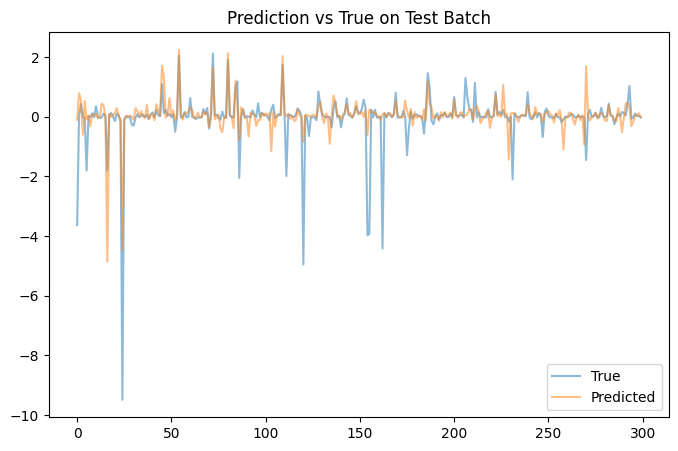

In [27]:
pyplot.figure(figsize=(8,5))
pyplot.plot(all_targets, label="True", alpha=0.5)
pyplot.plot(all_preds, label="Predicted", alpha=0.5)

pyplot.legend()
pyplot.title("Prediction vs True on Test Batch")
pyplot.show()

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

mse = root_mean_squared_error(all_targets, all_preds)
print(f"Test MSE on 600 samples: {mse:.6f}")

Test MSE on 600 samples: 0.734957


In [29]:
from sklearn.metrics import r2_score
r2 = r2_score(all_targets, all_preds)
print(f"Test R^2 on 600 samples: {r2:.6f}")

Test R^2 on 600 samples: 0.318982


In [30]:
numpy.corrcoef(all_targets, all_preds)

array([[1.        , 0.57624335],
       [0.57624335, 1.        ]])

In [31]:
print(zscored_t[:10].tolist())

[[-1.1308334601416816, -1.0998006075562712, 1.5110328711616015, 0.3891081455809783, 0.25713198266165727, 0.5267704795790628, -0.8445856354367913, -0.4104098044995507, -0.27809738393472505, -0.5175080842691001, -0.7515307225232557, -0.8738512409721908, 0.14356519728734093, -0.05189931908337762, 0.6303920003113677, 0.8691702286563687, 0.03487731014674328, -0.1321822138648737, -0.20033741640847355, -0.19050801090489874, -0.19219850672590091, -0.2393870409572032, -0.31441263792325647, -0.4107540072891993, -0.5615860882299047, -0.8528887214494169, 0.4594615426225321, 0.653982635270927, 0.9871611215894813, 1.3541820344783975, 1.6162537949622975, 1.6943153596329241, 1.6220982967234105, 1.431896842364629, 1.14693241929587, 0.8994528474079829, 0.08869295566823465, 0.41406033985627516, -0.35185244544976657, 0.6043311517686382, 1.134771417589932, -0.7645433689285407, -0.8686773568831588, 1.193790080121207, -0.5616124188299383, -0.5506227249795793, -0.6119927585281375, -0.7158761432549754, -0.8416